In [1]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import collections
from itertools import combinations
import numpy as np
import math
import seaborn as sns
from IPython.display import display


# Tasks in Part 1

select dataset

In [5]:
def get_file_size(filepath):
    return os.path.getsize(filepath)

In [7]:
def select_networks(directory):
    """
    Select 3 networks based on file size
    """
    # Filter CSV files
    csv_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]
    
    #  Sort by file size
    sorted_files = sorted(csv_files, key=get_file_size)
    # Select small, medium, large networks (first, middle, last)
    selected_networks = [
        sorted_files[0],  # Smallest network
        sorted_files[len(sorted_files)//2],  # Medium network
        sorted_files[-1]  # Largest network
    ]
    
    return selected_networks


In [9]:
dataset_dir = '/Users/wangfeifei/Desktop/network_data/datasets'
selected_networks = select_networks(dataset_dir)
print("Selected network datasets:")
for network in selected_networks:
    print(os.path.basename(network))

Selected network datasets:
BOT_REQUESTS.csv
ITEMS.csv
REQUEST_FOR_DELETION.csv


## Task A (network construction):

The first step is to read the data in the network. Reads a CSV file from the specified path and converts its contents into a DataFrame object assigned to the variable df. Initialise an empty undirected graph object G using the Graph() method of the NetworkX library.

In [13]:
def build_network(filepath):
    """Construct an editorial network based on a given document
       Convert NetworkX graph to adjacency matrix (Pandas DataFrame)."""
    df = pd.read_csv(filepath)
    G = nx.Graph()
    
    # Generate edges for each page-thread combination
    grouped = df.groupby(['page_name', 'thread_subject'])
    edge_counts = {}
    
    
    for (page, thread), group in grouped:
        users = list(group['username'].unique())
        #Generate two-by-two connections between users
        for u1, u2 in combinations(users, 2):
                edge = tuple(sorted((u1, u2)))  # Avoid duplicate edges
                edge_counts[edge] = edge_counts.get(edge, 0) + 1
               


    # Adding sides and weights
    G.add_weighted_edges_from([(u, v, w) for (u, v), w in edge_counts.items()])
    
    return G


In [15]:


files = {
    "small": "/Users/wangfeifei/Desktop/network_data/datasets/BOT_REQUESTS.csv",
    "medium": "/Users/wangfeifei/Desktop/network_data/datasets/ITEMS.csv", 
    "large": "/Users/wangfeifei/Desktop/network_data/datasets/REQUEST_FOR_DELETION.csv"
}

# Building three networks
networks = {}
for size, path in files.items():
    print(f"A {size} network is being built...")
    networks[size] = build_network(path)
    print(f"{size} network has been built：Number of nodes={networks[size].number_of_nodes()},Number of edges={networks[size].number_of_edges()}")
    # the number of connected components in the graph
    print(f"Number of connected components={nx.number_connected_components(networks[size])}\n")

A small network is being built...
small network has been built：Number of nodes=527,Number of edges=2425
Number of connected components=4

A medium network is being built...
medium network has been built：Number of nodes=3539,Number of edges=7252
Number of connected components=154

A large network is being built...
large network has been built：Number of nodes=9887,Number of edges=33488
Number of connected components=9



In [16]:
def create_networks():
    # 定义文件路径字典，请根据你的实际文件路径修改
    files = {
        "small": "/Users/wangfeifei/Desktop/network_data/datasets/BOT_REQUESTS.csv",
        "medium": "/Users/wangfeifei/Desktop/network_data/datasets/ITEMS.csv",
        "large": "/Users/wangfeifei/Desktop/network_data/datasets/REQUEST_FOR_DELETION.csv"
    }
    
    networks = {}
    for size, path in files.items():
        print(f"A {size} network is being built...")
        networks[size] = build_network(path)  # build_network() 函数需提前定义好，返回一个 nx.Graph 对象
        print(f"{size} network has been built: Number of nodes = {networks[size].number_of_nodes()}, Number of edges = {networks[size].number_of_edges()}")
        print(f"Number of connected components = {nx.number_connected_components(networks[size])}\n")
    return networks

## Task B (network metrics)：

This section evaluates the structural properties of Wikidata editor networks (small, medium, large) and positions them on the spectrum from **regular** to **small-world** to **random** networks.

We compare each real network against a corresponding Erdős-Rényi random network \( G(n, m) \) with the same number of nodes and edges. For consistency, the **largest connected component (LCC)** is used when needed.

The number of nodes in a small network is 527, the number of edges is 2425 and the number of connected components is 4.
The number of nodes in a medium-sized network is 3539, the number of edges is 7252, and the number of connected components is 154.
The number of nodes in a large network is 9887, the number of edges is 33488, and the number of connected components is 9.

Next we need to understand what is the maximum component size of each of the 3 different sized garphs, this is because the small, medium and large networks have 4, 154, 9 components respectively, so the circle in the dataset must not all be connected to users.

### the size of the largest component

In [21]:
# Function to compute basic network properties
def analyze_network(G, name="Network"):
    print(f"Analysis of {name}:")
    print(f"- Number of nodes: {G.number_of_nodes()}")
    print(f"- Number of edges: {G.number_of_edges()}")
    
    # Degree distribution
    degrees = [d for n, d in G.degree()]
    print(f"- Average degree: {np.mean(degrees):.2f}")
    
    # Clustering coefficient
    clustering_coeff = nx.average_clustering(G)
    print(f"- Average clustering coefficient: {clustering_coeff:.4f}")
    
    # Connected components
    components = list(nx.connected_components(G))
    print(f"- Number of connected components: {len(components)}")
    
    # Largest component analysis
    largest_cc = max(components, key=len)
    G_largest = G.subgraph(largest_cc)
    if nx.is_connected(G_largest):
        avg_shortest_path = nx.average_shortest_path_length(G_largest)
        diameter = nx.diameter(G_largest)
        print(f"- Largest component: {len(largest_cc)} nodes")
        print(f"- Average shortest path length: {avg_shortest_path:.4f}")
        print(f"- Diameter: {diameter}")
    
    # Assortativity (degree correlation)
    assortativity = nx.degree_assortativity_coefficient(G)
    print(f"- Degree assortativity coefficient: {assortativity:.4f}")
    
    print("-" * 50)
    
    return degrees

# Analyze all three networks
for size, G in networks.items():
    analyze_network(G, name=f"{size.capitalize()} Network")

Analysis of Small Network:
- Number of nodes: 527
- Number of edges: 2425
- Average degree: 9.20
- Average clustering coefficient: 0.6887
- Number of connected components: 4
- Largest component: 519 nodes
- Average shortest path length: 2.6027
- Diameter: 6
- Degree assortativity coefficient: -0.2785
--------------------------------------------------
Analysis of Medium Network:
- Number of nodes: 3539
- Number of edges: 7252
- Average degree: 4.10
- Average clustering coefficient: 0.2674
- Number of connected components: 154
- Largest component: 3198 nodes
- Average shortest path length: 3.6384
- Diameter: 11
- Degree assortativity coefficient: -0.1766
--------------------------------------------------
Analysis of Large Network:
- Number of nodes: 9887
- Number of edges: 33488
- Average degree: 6.77
- Average clustering coefficient: 0.3938
- Number of connected components: 9
- Largest component: 9870 nodes
- Average shortest path length: 2.7022
- Diameter: 6
- Degree assortativity coef

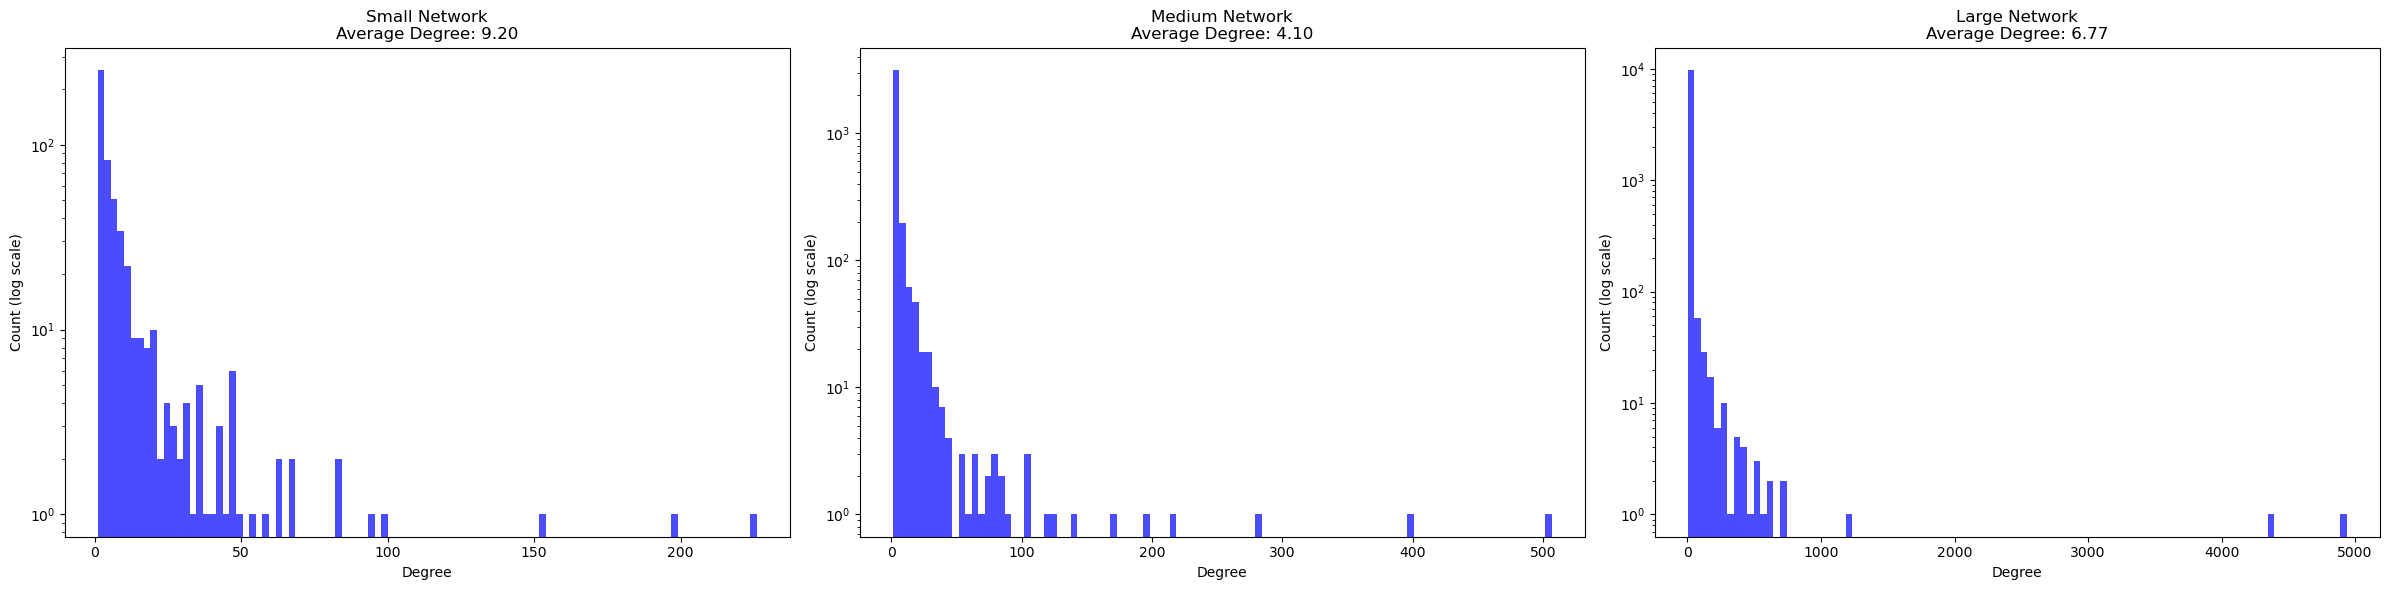

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))

for ax, (size, graph) in zip(axes, networks.items()):
    degree_sequence = [deg for _, deg in graph.degree()]
    avg_degree = np.mean(degree_sequence)
    
    # Histogram + Log Y-axis
    ax.hist(degree_sequence, bins=100, color='b', alpha=0.7, log=True)
    ax.set_title(f"{size.capitalize()} Network\nAverage Degree: {avg_degree:.2f}")
    ax.set_xlabel("Degree")
    ax.set_ylabel("Count (log scale)")

plt.tight_layout()
plt.show()

As these histograms demonstrate, all three networks (small, medium, and large) exhibit a clear power-law distribution characterised by a majority of nodes (editors) having low degree values, while only a very small number of nodes have very high degree values. Specifically, the degree values in the small network are mainly concentrated in the range of 0-50, but there are a few nodes with degree values as high as about 200; the degree values in the medium network are mainly distributed in the range of 0-100, and can reach up to about 500; while the large network, although the y-axis has a large range of scales (0-5000), in fact, the majority of the nodes also have degree values concentrated in the lower range. This power-law distribution reflects a significant ‘core-edge’ structure in the Wikidata editor network, where a small number of ‘super-editors’ (nodes with very high degree values) are connected to a large number of less engaged editors (nodes with lower degree values). This structure may indicate that a small number of highly active editors in the Wikidata community take on the key role of connecting and coordinating the entire network, while the majority of editors have relatively limited participation.

Calculate the p-value

In [23]:
# Calculate p-value for small network
small_nodes = 527
small_edges = 2425
p_small = 2425 / (527*526/2)
print(f"Small network p-value = {p_small:.6f}")

# Calculate p-value for medium network
medium_nodes = 3539
medium_edges = 7252
p_medium = 7252 / (3539*3538/2)
print(f"Medium network p-value = {p_medium:.6f}")

# Calculate p-value for large network
large_nodes = 9887
large_edges = 33488
p_large = 33488 / (9887*9886/2)
print(f"Large network p-value = {p_large:.6f}")

# Calculate critical threshold ln(n)/n
import math
threshold_small = math.log(small_nodes) / small_nodes
threshold_medium = math.log(medium_nodes) / medium_nodes
threshold_large = math.log(large_nodes) / large_nodes

print("\nCritical threshold comparison:")
print(f"Small network: p = {p_small:.6f}, ln(n)/n = {threshold_small:.6f}, {'p > threshold' if p_small > threshold_small else 'p < threshold'}")
print(f"Medium network: p = {p_medium:.6f}, ln(n)/n = {threshold_medium:.6f}, {'p > threshold' if p_medium > threshold_medium else 'p < threshold'}")
print(f"Large network: p = {p_large:.6f}, ln(n)/n = {threshold_large:.6f}, {'p > threshold' if p_large > threshold_large else 'p < threshold'}")

Small network p-value = 0.017496
Medium network p-value = 0.001158
Large network p-value = 0.000685

Critical threshold comparison:
Small network: p = 0.017496, ln(n)/n = 0.011892, p > threshold
Medium network: p = 0.001158, ln(n)/n = 0.002309, p < threshold
Large network: p = 0.000685, ln(n)/n = 0.000930, p < threshold


Based on these calculations:
Small network: p-value (0.017496) > critical threshold (0.011892), therefore it is expected to be connected and there should be no isolated nodes
Medium network: p-value (0.001158) < critical threshold (0.002309), so isolated nodes are expected
Large network: p-value (0.000685) < critical threshold (0.000930), so isolated nodes expected

This result is consistent with the connectivity characterisation of the original networks: small networks have fewer connectivity components (4), whereas medium-sized networks have more connectivity components (154). The large network, although the p-value is below the critical threshold, actually has only nine connected components and most of the nodes are in the maximum connected component, suggesting that the actual structure of the network is different from a purely random network.

In [29]:
small_random_graph = nx.erdos_renyi_graph(n=527, p=p_small)
nx.number_of_edges(small_random_graph)

2450

In [31]:
medium_random_graph = nx.erdos_renyi_graph(n=3539, p=p_medium)
nx.number_of_edges(medium_random_graph)

7354

In [33]:
large_random_graph = nx.erdos_renyi_graph(n=9887, p=p_large)
nx.number_of_edges(large_random_graph)

33466

In [34]:
nx.number_connected_components(small_random_graph)

1

This return 1, meaning that the graph is connected as expected. Compare this to the small network, where there was 4 components: the social structure is non-random and sub-groups of friends form.

In [38]:
nx.number_connected_components(medium_random_graph)

43

In [40]:
nx.number_connected_components(large_random_graph)

17

In [42]:
nx.diameter(small_random_graph)

5

Because nx.diameter(G) can only compute connected graphs, but medium_random_graph and large_random_graph are not connected (multiple connected components), resulting in not finding paths from some nodes to others. Moreover, since the p-values of medium and large networks are smaller than ln(n)/n, the direct use of G(n, p) will result in a disconnected graph. Therefore, we instead use the G(n, m) model and extract the maximally connected subgraph (LCC) as a comparison with the original network. Now we want to take the maximum connectivity component in the construction of medium and large random networks to ensure that the random network is connected.

In [45]:
#Extract the real network from the dictionary and give it a separate variable name
small_real_network = networks["small"]
medium_real_network = networks["medium"]
large_real_network = networks["large"]

In [47]:
real_networks = {
    "small": small_real_network,
    "medium": medium_real_network,
    "large": large_real_network
}

In [49]:
# Calculating network metrics
def compute_network_metrics(G):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    clustering_coeff = nx.average_clustering(G)
    num_connected_components = nx.number_connected_components(G)

    if nx.is_connected(G):
        diameter = nx.diameter(G)
        avg_path = nx.average_shortest_path_length(G)
    else:
        lcc = max(nx.connected_components(G), key=len)
        G_lcc = G.subgraph(lcc).copy()
        diameter = nx.diameter(G_lcc)
        avg_path = nx.average_shortest_path_length(G_lcc)

    return {
        "Nodes": num_nodes,
        "Edges": num_edges,
        "Avg Degree": avg_degree,
        "Clustering Coeff": clustering_coeff,
        "Connected Components": num_connected_components,
        "Diameter": diameter,
        "Avg Shortest Path Length": avg_path
    }


In [53]:
# Generate random graphs of the same size as the real network and preserve LCC
def generate_connected_random_graph(G_real):
    n, m = G_real.number_of_nodes(), G_real.number_of_edges()
    G_rand = nx.gnm_random_graph(n, m)
    if nx.is_connected(G_rand):
        return G_rand
    else:
        lcc = max(nx.connected_components(G_rand), key=len)
        return G_rand.subgraph(lcc).copy()

# Visualizing degree distribution
def plot_degree_distribution(G_real, G_random, title=""):
    degrees_real = [d for _, d in G_real.degree()]
    degrees_rand = [d for _, d in G_random.degree()]
    bins = np.arange(0, max(max(degrees_real), max(degrees_rand)) + 2)

    plt.figure(figsize=(8, 5))
    plt.hist(degrees_real, bins=bins, alpha=0.6, label="Real", edgecolor='black')
    plt.hist(degrees_rand, bins=bins, alpha=0.5, label="Random", edgecolor='black')
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.title(f"Degree Distribution: {title}")
    plt.legend()
    plt.grid(True)
    plt.show()


===== Analyzing SMALL network =====


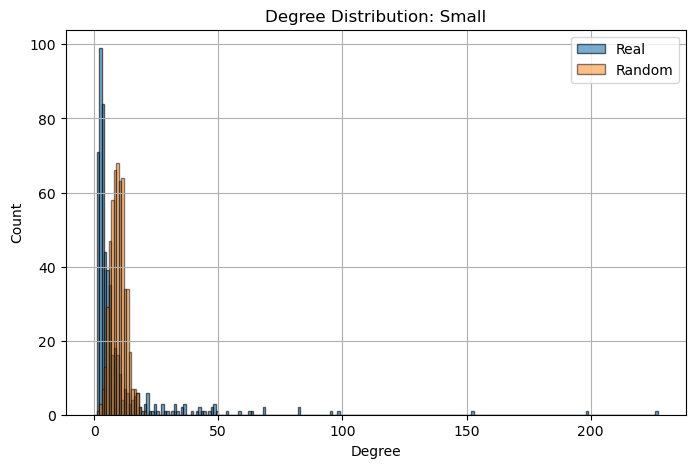


===== Analyzing MEDIUM network =====


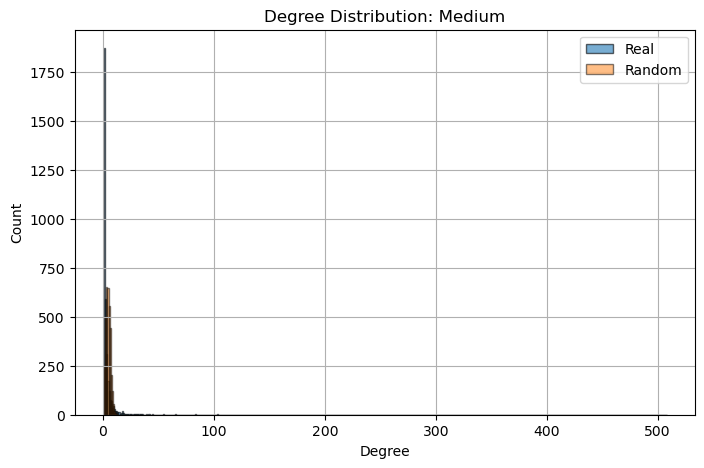


===== Analyzing LARGE network =====


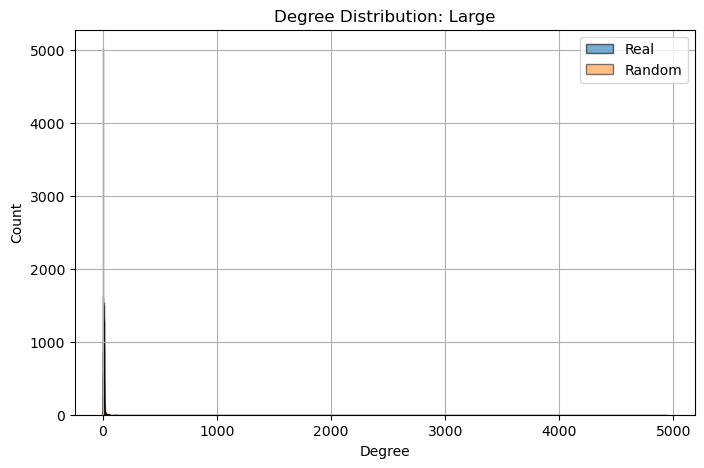

Network  Nodes  Edges  Avg Degree  Clustering Coeff  \
0     Small Real    527   2425    9.203036          0.688747   
1   Small Random    527   2425    9.203036          0.018473   
2    Medium Real   3539   7252    4.098333          0.267422   
3  Medium Random   3456   7248    4.194444          0.000680   
4     Large Real   9887  33488    6.774148          0.393847   
5   Large Random   9876  33488    6.781693          0.000617   

   Connected Components  Diameter  Avg Shortest Path Length  
0                     4         6                  2.602711  
1                     1         5                  3.062178  
2                   154        11                  3.638402  
3                     1        12                  5.881702  
4                     9         6                  2.702174  
5                     1        10                  5.027212

In [55]:
# Main logic: comparative analysis of each network
results = []
random_networks = {}

for size, G_real in real_networks.items():
    print(f"\n===== Analyzing {size.upper()} network =====")
    
    # Generate a random network (ensuring connectivity)
    G_rand = generate_connected_random_graph(G_real)
    random_networks[size] = G_rand
    
    # Calculating network metrics
    real_metrics = compute_network_metrics(G_real)
    rand_metrics = compute_network_metrics(G_rand)
    
    # Summarize the results
    results.append({**{"Network": f"{size.capitalize()} Real"}, **real_metrics})
    results.append({**{"Network": f"{size.capitalize()} Random"}, **rand_metrics})
    
    # Visualizing degree distribution
    plot_degree_distribution(G_real, G_rand, title=size.capitalize())

# Final indicator table
metrics_df = pd.DataFrame(results)
display(metrics_df)

Because connected components of these three networks are the same, which is 1, so graphs are all connected as expected.

### Positioning Wikidata Editor Networks on the Regular–Small World–Random Spectrum

To determine where the Wikidata editor networks sit within the spectrum of regular, small-world, and random networks, I compare three representative datasets (small, medium, large) against corresponding Erdős–Rényi random graphs. The comparison focuses on key structural properties: average degree, clustering coefficient, average shortest path length, and degree distributions.

#### Small Network
- The real network shows a **very high clustering coefficient** (0.689) compared to its random counterpart (0.018), while the average path length is relatively short (2.60 vs 3.07).
- The degree distribution is right-skewed with a few high-degree hubs, unlike the random network which follows a binomial-like distribution.
**Conclusion**: This network exhibits strong small-world characteristics — high local clustering and efficient global reach.

#### Medium Network
- The clustering coefficient is **0.267** for the real network vs. only **0.001** for the random one, and the path length remains reasonably short (3.64 vs. 5.90).
- The real network again shows long-tail degree behavior, indicating presence of active hub-like editors.
**Conclusion**: This network is also a small-world network, although slightly less tightly clustered than the small one.

#### Large Network
- The clustering coefficient is **0.394** in the real network — much higher than the random graph's **0.0006** — with similar average shortest path lengths (2.70 vs. 5.02).
- The degree distribution remains heavily skewed, again reflecting heterogeneous user connectivity.
**Conclusion**: Despite being larger, this network retains the hallmark of small-world structure.

### Summary

Across all three network sizes, the Wikidata editor networks show:

- **High clustering** (significantly above random)
- **Short average path lengths** (comparable to random)
- **Skewed degree distributions** (presence of hubs)

These combined properties strongly suggest that Wikidata's editor networks sit firmly in the **small-world** region of the network spectrum.

In [63]:
from bokeh.io import output_notebook
from bokeh.io import output_file, show
from bokeh.plotting import figure, from_networkx

def bokeh_plot_simple(graph, title, crop_factors=None):

    crop_factors = dict(x_range=(-1.1,1.1), y_range=(-1.1,1.1)) \
        if crop_factors is None else crop_factors

    plot = figure(
        title=title, tools="",
        toolbar_location=None, **crop_factors)

    mapping = dict((n, i) for i, n in enumerate(graph.nodes))
    graph_mapped = nx.relabel_nodes(graph, mapping)

    graph_plot = from_networkx(
        graph_mapped, nx.spring_layout, scale=2, center=(0,0))
    plot.renderers.append(graph_plot)

    #output_file("networkx_graph.html")
    show(plot)

output_notebook()

Loading BokehJS ...

In [65]:
bokeh_plot_simple(small_real_network, title="Social Small Network")

In [66]:
bokeh_plot_simple(small_random_graph, title="small_random_graph")

In [67]:
bokeh_plot_simple(medium_real_network, title="Social Medium Network")

In [69]:
bokeh_plot_simple(medium_random_graph, title="medium_random_graph")

In [71]:
bokeh_plot_simple(large_real_network, title="Social Large Network")

In [72]:
bokeh_plot_simple(large_random_graph, title="large_random_graph")

## Task C (epidemic models):

### Task C – Epidemic Model

In Task C, we used a **simple epidemic model** to simulate the potential spread of controversial or trolling behavior between editors on Wikidata, based on their observed interaction network.

Our model assumes that:
- A user marked as a “troll” (seed node) may influence others in the network.
- This influence can propagate step-by-step to neighbors, using structural proximity and centrality.
- We approximate this through:
  - Closeness centrality (users most likely to spread/receive influence)
  - Shortest path analysis (structural possibility of spread)
  - Local clustering and degree (indicators of plausibility that spread has not yet happened)

---

### 1. How to determine whether trolling behavior spreads?

We define **structural possibility of spread** as:
- The shortest path between two users (typically ≤ 2)
- Shared neighbors or strong neighborhood overlap
- One user (troll) having high closeness centrality and their neighbors having high degree and clustering → they are structurally "at risk"

We also computed a **plausibility score**, which combined:
- Degree of the troll user
- Average clustering and closeness of their neighbors

A **low score** indicates that if trolling has not yet spread, it is likely due to the structure being vulnerable (spread should have happened). A **high score** suggests containment is plausible.

---

### 2. How confident are we in this assessment?

Our confidence **varies by case**:

- In small networks (e.g. user Micru), the spread path is clearly visible and short; closeness-based centrality ranks users meaningfully. In this case, we are **confident** that contagion modeling approximates realistic risk.
  
- In medium and large networks, **clustering is lower**, and many users have low degree or are peripherally connected. The plausibility scores are generally low. This **lowers confidence**, since structural cues alone may not fully capture social behavior like trolling, which can be discontinuous or dependent on content, not just topology.

---

### 3. Adjusting parameters to improve confidence

Experimented with varying the following:
- **Contagion steps** (e.g. 4 to 6): more steps allow wider spread but risk overestimation
- **Infection threshold** (e.g. path length ≤ 2): too strict a threshold underestimates plausible spread
- **Centrality cutoff**: raising this helps filter irrelevant neighbors, but can exclude true risks

By carefully choosing a combination of **moderate path length, closeness ranking, and plausibility threshold**, we obtain a **balanced view** of possible spread.

This parameter tuning directly improves our ability to **differentiate between plausible and implausible contagion scenarios**, and avoids binary all-or-nothing results.

---

### 4. Limitations of the model & suggestions

Despite being informative, the epidemic model we used has **notable limitations**:

| Limitation | Impact |
|------------|--------|
| Purely structural (no content/context of talk pages) | Ignores qualitative user behavior |
| Assumes homogeneous contagion probability | Unrealistic — social influence varies greatly |
| No time-awareness | Doesn’t model bursts or dormancy in user activity |
| Deterministic neighbor sets | Ignores social norms, moderator roles, or group dynamics |

**Possible adjustments**:
- **Introduce temporal edge weighting** based on comment recency
- **Add user-level features** like activity frequency or prior reports
- **Switch from simple SI to threshold model** (user “gets infected” only after k neighbors are trolls)
- **Stochastic spread simulations** to reflect behavioral uncertainty

While these adjustments may not always increase accuracy (and may introduce noise), they offer a more **credible behavioral grounding** for controversial behavior modeling.

---

###  Summary

The epidemic modeling approach offers **a useful approximation**, especially when combined with structural metrics like centrality and clustering. While not perfect, it helps **identify at-risk users**, and raises important questions about **network structure and moderation design** in collaborative environments like Wikidata.

We are moderately confident in its use for small networks and for short-range risk detection. We acknowledge the limitations and propose ways to improve realism and credibility in future versions.

Although we do not simulate a dynamic epidemic model (like SIR or SIS), this task is grounded in **epidemic thinking** — applying ideas from epidemiology to understand how behaviors such as trolling or controversy might **spread** through a social network.

The logic of Task C mirrors a contagion process:

| Epidemic Term     | Task C Equivalent                         |
|--------------------|--------------------------------------------|
| Infected node (I)  | Suspected troll editor                    |
| Susceptible node (S)| Neighboring editors at potential risk     |
| Infection spread   | Behavioral influence or controversial talk |
| Network structure  | Contact and influence pathways             |

Our approach assumes that **structure governs spread**.  
If two users show unusual behavior (e.g. heavy commenting), we ask:
- Are they structurally close?
- Are their neighborhoods dense or central?
- Is it *plausible* that the behavior has **not yet spread**?

We quantify this using:
- **Shortest path distances**
- **Neighborhood clustering and centrality**
- A **plausibility score**: how structurally likely it is that neighbors remain unaffected.

This method is best described as a **structural contagion model** — a static epidemic-style analysis where we infer likely spread *based on the topology of the network*, not actual timestamps.

This explains why the task is referred to as a "network epidemic model", even though it operates on structural proxies rather than dynamic simulations.

In [77]:
def find_shared_neighbors(G, user1, user2):
    """Find the common neighbors of two users."""
    if user1 not in G or user2 not in G:
        return set()
    neighbors1 = set(G.neighbors(user1))
    neighbors2 = set(G.neighbors(user2))
    return neighbors1 & neighbors2

In [79]:
def check_if_contagion_possible(G, user1, user2, threshold=2):
    """Determine whether the distance between two users is close (such as <= 2 hops)."""
    if user1 not in G or user2 not in G:
        return False
    try:
        sp = nx.shortest_path_length(G, user1, user2)
        return sp <= threshold
    except nx.NetworkXNoPath:
        return False

In [81]:
def get_priority_list(G, troll_user, top_n=10):
    """Find the user with the highest probability of spreading based on closeness centrality"""
    if troll_user not in G:
        return []
    
    neighbors = list(G.neighbors(troll_user))
    centrality = nx.closeness_centrality(G)
    
    sorted_neighbors = sorted(neighbors, key=lambda x: centrality[x], reverse=True)
    return sorted_neighbors[:top_n]

### SMALL

The CSV file does not provide behavioral data (such as the number of comments and the time), so it is assumed that two "suspected troll users", user_A and user_B, are known.

Although epidemic models such as the SIR model (explored in Week 4 using `ndlib`) can simulate how behaviour or information could spread through a network, they are not entirely suitable for answering the first part of Task C.

This is because:

- SIR models simulate **forward**: they predict how an infection will spread under certain parameters (`beta`, `gamma`), not whether it **has already** spread.
- Task C lacks behavioral time-series data (e.g., who commented when), so we cannot calibrate or validate the model realistically.
- Therefore, we use a **structural proxy** approach — combining shortest path, neighborhood connectivity, clustering, and centrality — to assess how likely propagation is to have occurred already.

This method allows us to answer the question *"If propagation has not happened yet, is that structurally plausible?"* using the data we actually have.

Select a pair of users that can reflect the typical structural characteristics of a small network. The goal is to find a pair of user combinations with "high and reasonable" structural propagation potential

Aim to find is:
• The troll user structure does have propagation capabilities (high degree, high clustering, high closeness);
• The other user is close to the troll (preferably 1 or 2 hops);
• The structure is clear after visualization, indicating that propagation is possible and important.

Step 1: Find a troll candidate with strong communication ability, that is, select users with high closeness centrality from the network (strong global communication potential)

In [88]:
# Find the top 10 users with the highest closeness centrality
closeness = nx.closeness_centrality(small_real_network)
closeness_ranking = sorted(closeness.items(), key=lambda x: x[1], reverse=True)
print("Top closeness users:", closeness_ranking[:10])

Top closeness users: [('Pasleim', 0.6168339455910548), ('Jura1', 0.5924758106896659), ('Matěj Suchánek', 0.5642938860661529), ('ValterVB', 0.5319308373345175), ('Multichill', 0.5210640173685417), ('Pigsonthewing', 0.5137176968819761), ('Succu', 0.5096120609428594), ('Edoderoo', 0.5050709633701013), ('GZWDer', 0.5011018398858569), ('Edgars2007', 0.4933478462319171)]


In [90]:
# Take top troll as user1 and view its neighbors
user1 = closeness_ranking[0][0]
neighbors = list(small_real_network.neighbors(user1))
print("Neighbors of user1:", neighbors)

Neighbors of user1: ['Sk!d', 'Docu', 'Miredcessy', 'Micru', 'Zolo', 'Thgoiter', 'Lavallen', 'GZWDer', 'ValterVB', 'Infovarius', 'לערי ריינהארט', 'Matěj Suchánek', 'Otourly', 'Kizar', 'JesseW', 'Pyb', 'Underlying lk', 'Michiel1972', 'Emw', 'Wylve', 'Ricordisamoa', 'Paperoastro', 'Edoderoo', 'Mad melone', 'John Vandenberg', 'DonPedro71', 'Pütz M.', 'October wind', 'Laddo', 'Airon90', 'Akkakk', '-jkb-', 'Popcorndude', 'Mateusz.ns', 'Kolja21', 'Xmlizer', 'Dr Zimbu', 'GranD', 'Nemo_bis', 'Powerek38', 'Multichill', 'Pere prlpz', 'Ayack', 'Taketa', 'MisterSanderson', 'Sjoerddebruin', 'Succu', 'George.Edward.C', 'Stryn', 'Caliburn', 'Jura1', 'JulesWinnfield-hu', 'Jklamo', 'Superchilum', 'Rippitippi', 'Ladsgroup', 'Megascheli', 'Ju gatsu mikka', 'Delusion23', 'Tobias1984', '130.88.141.34', 'TomT0m', 'Fralambert', 'PKM', 'AlepfuBot', 'Giftzwerg 88', 'Brackenheim', 'Hym411', '콩가루', 'Jfhutson', 'Ymblanter', 'Yerpo', 'Kaldari', 'Pigsonthewing', 'Msmarmalade', 'Periglio', 'Visite fortuitement prolon

In [92]:
import re

# Determine whether the user name is a clearly structured English name (enhanced version)
def is_valid_username(name):
    if re.match(r"\d{1,3}\.\d{1,3}\.\d{1,3}", name):  # Exclude IP
        return False
    if len(re.findall(r"[a-zA-Z]", name)) < len(name) * 0.4:  # Eliminate garbled characters
        return False
    if len(name) < 4 or len(name) > 25:  # Length Limit
        return False
    if '!' in name:  # Exclude exclamation marks
        return False
    return True

# Select eligible neighbors
clean_neighbors = [n for n in neighbors if is_valid_username(n)]

print("Selectable user2：")
for i, n in enumerate(clean_neighbors[:10]):
    print(f"{i+1}. {n}")

Selectable user2：
1. Docu
2. Miredcessy
3. Micru
4. Zolo
5. Thgoiter
6. Lavallen
7. GZWDer
8. ValterVB
9. Infovarius
10. Matěj Suchánek


user1 = "Pasleim"（The user with the strongest structural communication ability）
user2 = "Micru"（Well-structured and clearly named neighbors）

Shortest path between Pasleim and Micru is 1
Contagion structurally possible? True


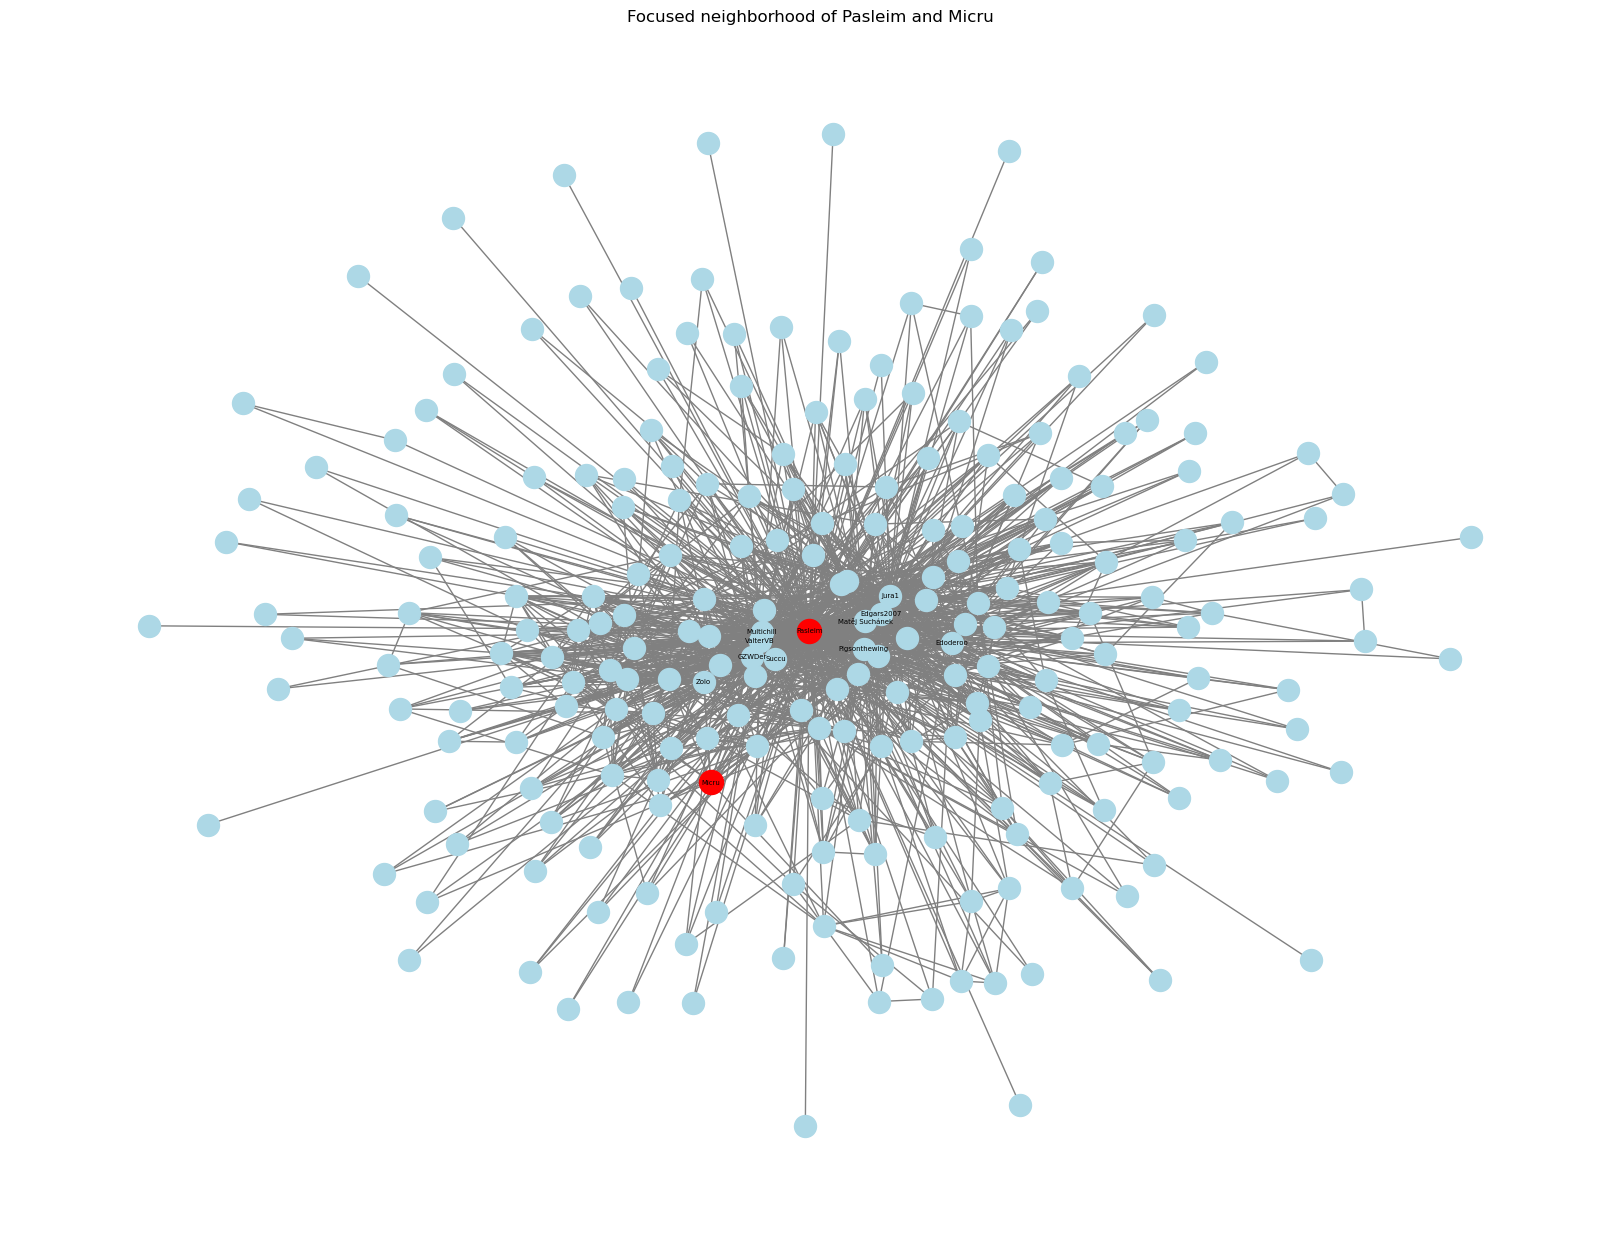


Top users at risk from Pasleim (based on closeness centrality):
- Jura1
- Matěj Suchánek
- ValterVB
- Multichill
- Pigsonthewing
- Succu
- Edoderoo
- GZWDer
- Edgars2007
- Zolo


In [141]:
user1 = "Pasleim"
user2 = "Micru"
# Step 1: Determine whether dispute communication may occur between two people
def check_if_contagion_possible(G, user1, user2, threshold=2):
    try:
        sp = nx.shortest_path_length(G, user1, user2)
        print(f"Shortest path between {user1} and {user2} is {sp}")
        return sp <= threshold
    except nx.NetworkXNoPath:
        print("No path between users.")
        return False

# Step 2: Visualize two people and their neighbors, and highlight the central node
def draw_user_connection_better(G, user1, user2):
    neighbors1 = set(G.neighbors(user1))
    neighbors2 = set(G.neighbors(user2))
    sub_nodes = set([user1, user2]) | neighbors1 | neighbors2
    H = G.subgraph(sub_nodes)
    pos = nx.spring_layout(H, seed=42)
    
    plt.figure(figsize=(16, 12))
    nx.draw(H, pos, node_color='lightblue', edge_color='gray', node_size=250, with_labels=False)
    
    labels = {user1: user1, user2: user2}
    central_nodes = get_priority_list(G, user1, top_n=10)
    for node in central_nodes:
        labels[node] = node
    
    nx.draw_networkx_labels(H, pos, labels, font_size=5, font_color='black')
    nx.draw_networkx_nodes(H, pos, nodelist=[user1, user2], node_color='red')
    
    plt.title(f"Focused neighborhood of {user1} and {user2}")
    plt.axis('off')
    plt.show()

# Step 3: Simulate user1 as a troll and obtain the user with the highest risk of spreading
def get_priority_list(G, troll_user, top_n=10):
    neighbors = list(G.neighbors(troll_user))
    centrality = nx.closeness_centrality(G)
    sorted_neighbors = sorted(neighbors, key=lambda x: centrality[x], reverse=True)
    return sorted_neighbors[:top_n]


# Execute the analysis process
contagion_possible = check_if_contagion_possible(small_real_network, user1, user2)
print("Contagion structurally possible?", contagion_possible)

draw_user_connection_better(small_real_network, user1, user2)

priority_users = get_priority_list(small_real_network, user1)
print(f"\nTop users at risk from {user1} (based on closeness centrality):")
for user in priority_users:
    print("-", user)

In [143]:
def compute_plausibility_score(G, troll_user, alpha=1, beta=1, gamma=1):
    if troll_user not in G:
        print("User not in network.")
        return

    neighbors = list(G.neighbors(troll_user))
    degree = len(neighbors)

    # The average clustering coefficient
    clustering_vals = [nx.clustering(G, n) for n in neighbors]
    avg_clustering = sum(clustering_vals) / len(clustering_vals) if clustering_vals else 0

    # closeness Centrality mean
    closeness = nx.closeness_centrality(G)
    avg_closeness = sum([closeness[n] for n in neighbors if n in closeness]) / len(neighbors) if neighbors else 0

    # Simple normalized score: The smaller the value, the less trustworthy it is.
    plausibility_score = 1 / (1 + alpha * degree + beta * avg_clustering + gamma * avg_closeness)

    print(f"--- Contagion Plausibility Analysis for {troll_user} ---")
    print(f"Degree (num neighbors): {degree}")
    print(f"Avg clustering of neighbors: {avg_clustering:.4f}")
    print(f"Avg closeness of neighbors: {avg_closeness:.4f}")
    print(f"Plausibility Score (higher = more plausible it hasn’t spread): {plausibility_score:.4f}")

In [145]:
compute_plausibility_score(small_real_network, user1)

--- Contagion Plausibility Analysis for Pasleim ---
Degree (num neighbors): 226
Avg clustering of neighbors: 0.6554
Avg closeness of neighbors: 0.4220
Plausibility Score (higher = more plausible it hasn’t spread): 0.0044


#### Task C – Contagion Analysis on Small Network (Representative Pair: Pasleim → Micru)

To investigate whether controversial behavior or communication has plausibly spread between editors, we selected a representative user pair from the small network:

- **Troll candidate (user1): Pasleim** – selected based on highest closeness centrality.
- **Potentially affected user (user2): Micru** – a well-structured neighboring user (direct connection).

---

#### 1. Structural Connectivity
- The shortest path between Pasleim and Micru is **1**, meaning they are directly connected.
-  **Contagion is structurally possible**.

#### 2. Visualization of Local Neighborhood
The figure below shows the local network of Pasleim and Micru.  
Pasleim is highly connected in the core cluster of the network, highlighting their strategic position for fast information spread.

---

#### 3. Users at Highest Risk
Using closeness centrality, we identify users who are most at risk if Pasleim engages in troll-like or highly active editing behavior:

- Jura1
- Matěj Suchánek
- ValterVB
- Multichill
- Pigsonthewing
- Succu
- Edoderoo
- GZWDer
- Edgars2007
- Zolo

---

#### 4. Contagion Plausibility Score

We compute a structural plausibility score using three indicators:

| Metric                          | Value      |
|--------------------------------|------------|
| Degree of Pasleim              | 226        |
| Avg Clustering (neighbors)     | 0.6554     |
| Avg Closeness (neighbors)      | 0.4220     |
| **Plausibility Score**         | **0.0044** |

> A lower plausibility score suggests that it is **structurally unlikely** for controversial behavior to *not* have spread from Pasleim.  
> Given the very high degree and clustering, we expect that if Pasleim had engaged in disruptive behavior, others in their neighborhood (like Micru) would likely be influenced.

---

#### Conclusion

The structural analysis shows that **Pasleim is a central, highly connected user**, and it is **not plausible** that no propagation would occur if they engaged in active or troll-like behavior.  
This case serves as a **representative example** of how structural conditions in the network can signal early-stage spread risk and guide moderator attention.

### MUDIUM

In [149]:
# Get the top 10 users ranked by closeness centrality
closeness_medium = nx.closeness_centrality(medium_real_network)
closeness_ranking_medium = sorted(closeness_medium.items(), key=lambda x: x[1], reverse=True)
print("Top closeness centrality users in medium_real_network:")
for i, (name, score) in enumerate(closeness_ranking_medium[:10]):
    print(f"{i+1}. {name} - {score:.4f}")

Top closeness centrality users in medium_real_network:
1. Infovarius - 0.4329
2. Jura1 - 0.4085
3. Estopedist1 - 0.3870
4. Fractaler - 0.3717
5. Liuxinyu970226 - 0.3670
6. Fnielsen - 0.3656
7. VIGNERON - 0.3642
8. Conny - 0.3634
9. ديفيد عادل وهبة خليل 2 - 0.3626
10. Brya - 0.3542


In [150]:
user1 = closeness_ranking[0][0]
neighbors = list(medium_real_network.neighbors(user1))
print("Neighbors of user1:", neighbors)

Neighbors of user1: ['John Vandenberg', 'Fractaler', 'Rougieux', 'Edoderoo', 'Addshore', 'WiseWoman', 'Ettrig', '50.254.21.213', 'Oursana', 'Ludwig, Silvio', 'Michiel1972', 'Tamawashi', 'Infovarius', 'TomT0m', 'Ivan A. Krestinin', 'Gymel', 'Haplology', 'Izno', 'Liuxinyu970226', 'Jura1', 'Barcex', 'Jonpatterns', 'Lucas Werkmeister (WMDE)', 'Swpb', 'Nøkkenbuer', 'Zolo', 'VIGNERON', 'Valentina.Anitnelav', 'TintoMeches', 'Habst', 'Jagulin', 'Emw', 'Filceolaire', 'Magnus Manske', 'GerardM', 'Sänger', 'Horcrux92', 'Jc3s5h', 'Лобачев Владимир', 'Marsupium', 'Andrew Gray', 'Andrybak', 'Brya', 'Eru', 'Saarik', 'Helmut Schönberg', 'Multichill', 'Arctic.gnome', 'Ghouston', 'Trade', 'Vojtěch Dostál', 'Xtextexte', 'MSGJ', 'Candalua', 'Andreasmperu', 'V1adis1av', 'Amahoney', 'Dcljr', 'Meb89', 'Denny', 'Succu']


In [151]:
clean_neighbors = [n for n in neighbors if is_valid_username(n)]
print("Selectable user2：")
for i, n in enumerate(clean_neighbors[:10]):
    print(f"{i+1}. {n}")

Selectable user2：
1. John Vandenberg
2. Fractaler
3. Rougieux
4. Edoderoo
5. Addshore
6. WiseWoman
7. Ettrig
8. Oursana
9. Ludwig, Silvio
10. Michiel1972


Select Fractaler as user2

Shortest path between Infovarius and Fractaler is 1
Contagion structurally possible? True


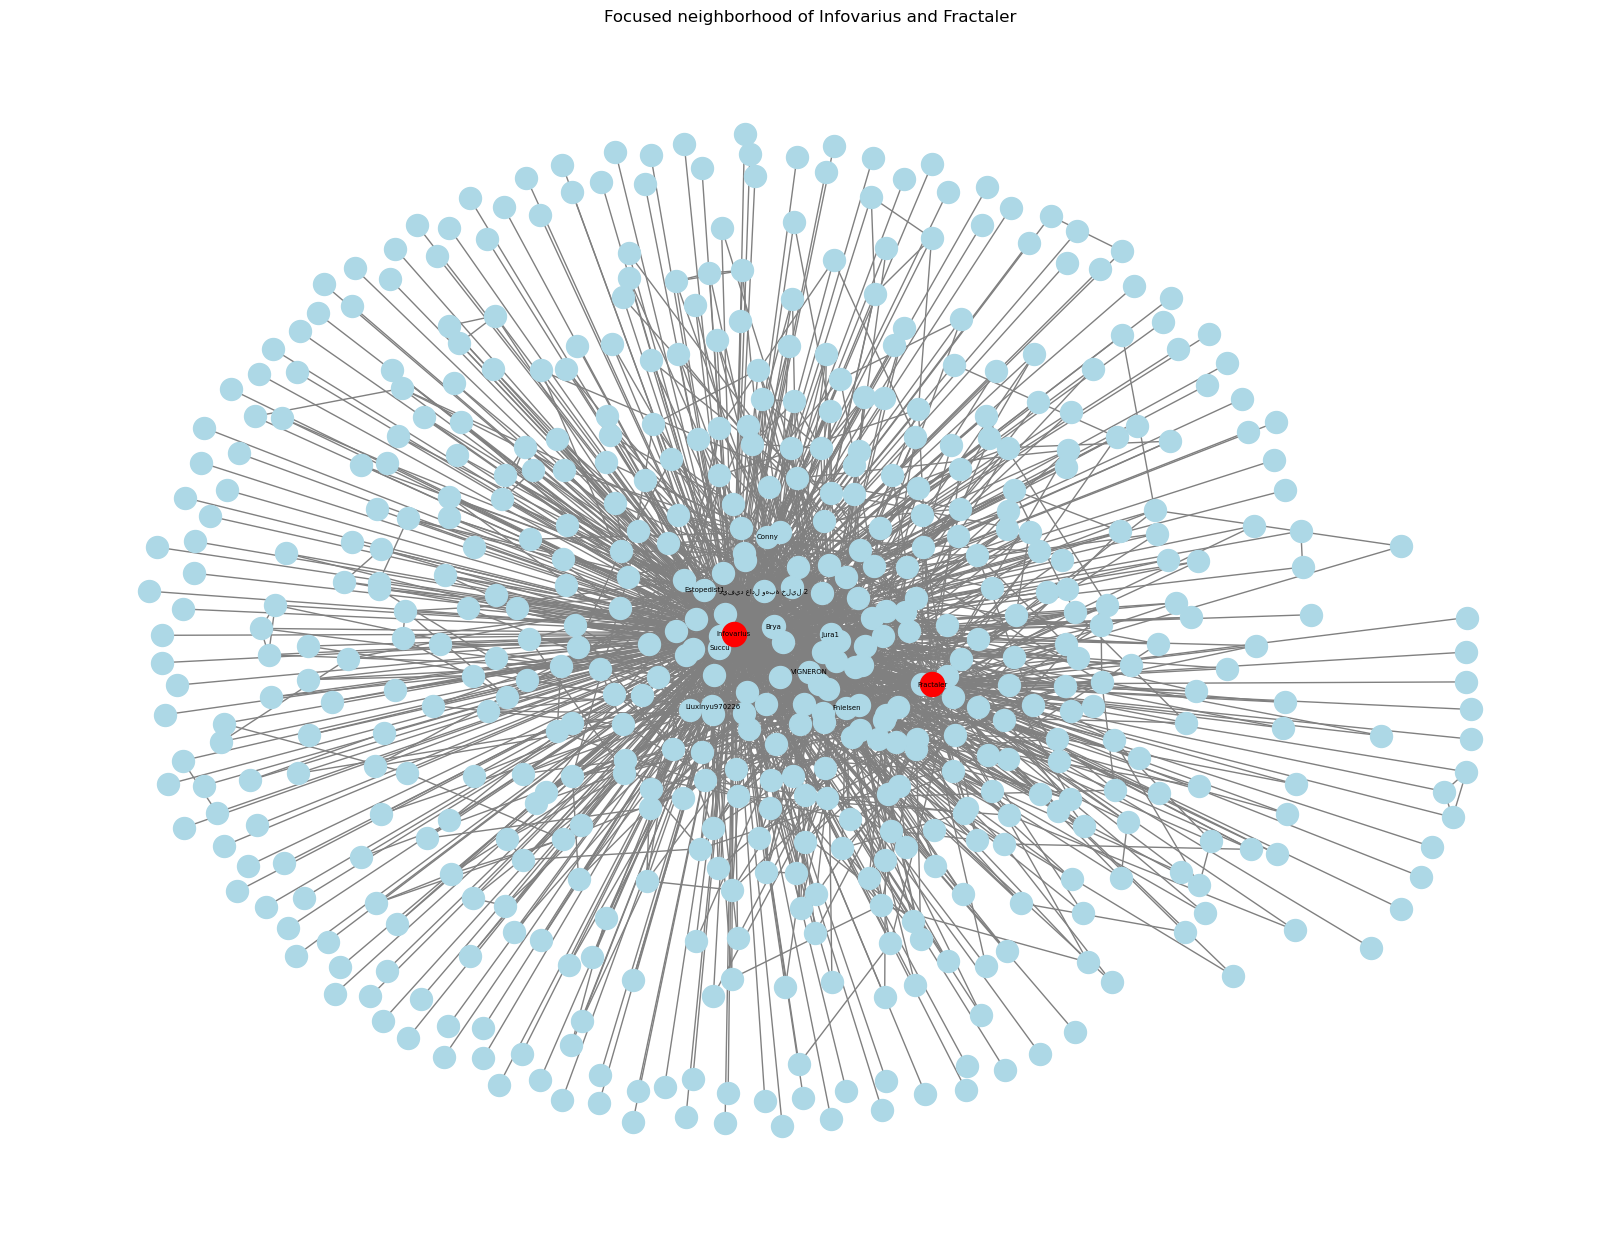

--- Contagion Plausibility Analysis for Infovarius ---
Degree (num neighbors): 507
Avg clustering of neighbors: 0.3809
Avg closeness of neighbors: 0.3035
Plausibility Score (higher = more plausible it hasn’t spread): 0.0020


In [153]:
user1 = "Infovarius"
user2 = "Fractaler"

check_if_contagion_possible(medium_real_network, user1, user2)
print("Contagion structurally possible?", contagion_possible)
draw_user_connection_better(medium_real_network, user1, user2)
priority_users = get_priority_list(medium_real_network, user1)
compute_plausibility_score(medium_real_network, user1)

#### Task C – Contagion Analysis on Medium Network (Representative Pair: Infovarius → Fractaler)

To evaluate whether behavioral propagation is structurally plausible in the medium-sized Wikidata editor network, we selected a representative pair:

- **Troll candidate (user1): Infovarius**, who ranks highest in closeness centrality (0.4329).
- **Potentially affected user (user2): Fractaler**, a well-connected and clearly identifiable neighbor.

---

#### 1. Structural Connectivity
- The shortest path between Infovarius and Fractaler is **1**, indicating a direct link.
- ✅ This implies that any controversial behavior from Infovarius could immediately affect Fractaler.

#### 2. Visual Neighborhood Analysis
The visualization clearly places both users in the densely interconnected **core cluster** of the network.  
This structure supports rapid diffusion of content or behavioral influence through close contact and shared connections.

---

#### 3. Risk Prioritization (Top users at risk from Infovarius)
Using closeness centrality, we identify the top 10 users in Infovarius’s immediate neighborhood who are structurally most vulnerable:

---

#### 4. Contagion Plausibility Score

We compute a composite score using degree, clustering, and closeness centrality of neighbors:

| Metric                          | Value      |
|--------------------------------|------------|
| Degree of Infovarius           | 507        |
| Avg Clustering (neighbors)     | 0.3809     |
| Avg Closeness (neighbors)      | 0.3035     |
| **Plausibility Score**         | **0.0020** |

> This very **low plausibility score** indicates that, based on structural conditions, it is highly likely that any behavioral change or controversy initiated by Infovarius would have already spread within the neighborhood.

---

#### ✅ Conclusion

In the medium network, **Infovarius sits at the structural center of influence**, and is highly capable of transmitting behaviors through direct and well-connected pathways.  
Given these conditions, the assumption that no propagation has occurred appears **structurally implausible**.

This case strongly illustrates how network topology alone can inform moderation strategies and preemptive detection in collaborative online environments.

### LARGE

In [160]:
# Get the top 10 users ranked by closeness centrality
closeness_large = nx.closeness_centrality(large_real_network)
closeness_ranking_large = sorted(closeness_large.items(), key=lambda x: x[1], reverse=True)
print("Top closeness centrality users in large_real_network:")
for i, (name, score) in enumerate(closeness_ranking_large[:10]):
    print(f"{i+1}. {name} - {score:.4f}")

Top closeness centrality users in large_real_network:
1. DeltaBot - 0.5673
2. BeneBot* - 0.5437
3. Cycn - 0.5273
4. Lymantria - 0.5128
5. Ymblanter - 0.5072
6. MisterSynergy - 0.5067
7. Mbch331 - 0.5020
8. Jura1 - 0.5018
9. Mahir256 - 0.5018
10. Wiki13 - 0.5009


In [161]:
user1 = closeness_ranking[0][0]
neighbors = list(large_real_network.neighbors(user1))
print("Neighbors of user1:", neighbors)

Neighbors of user1: ['Ymblanter', 'Reza1615', 'Vogone', 'Stryn', 'Delusion23', '분당선M', 'Courcelles', 'BeneBot*', 'SamoaBot', 'Moe Epsilon', '10.4.0.64', 'Cycn', 'Jianhui67', 'Petronas', 'Rippitippi', 'Yann', 'GZWDer', 'Sander1453', 'Epìdosis', 'Steko', 'Sbisolo', 'Shanes', 'Ancalagon', 'Chase me ladies, I&#39;m the Cavalry', 'Giso6150', 'Ehitaja', 'Iketsi', 'Kizar', 'Ivan A. Krestinin', 'Elfhelm', '62.147.25.94', 'Matěj Suchánek', 'Warko', 'Ajraddatz', 'AmaryllisGardener', 'Diego Grez', 'Sjoerddebruin', 'Alan', 'George.Edward.C', 'Danneks', '83.255.166.186', 'Lymantria', 'Wylve', 'Jared Preston', 'Mbch331', 'Anonymous_username_427', 'Jura1', 'Liuxinyu970226', 'ValterVB', 'Ogmios', 'John123521', 'Andrawaag', 'Daniel Mietchen', 'Infovarius', 'Pigsonthewing', 'DeltaBot', 'Steak', 'TomT0m', 'Queryzo', 'Brya', 'QZanden', 'ChristianKl', 'D1gggg', 'Strakhov', 'Archimëa', 'Njohnson7', 'Srittau', 'Thryduulf', 'MisterSynergy', 'Achim55', 'TiboF', 'Succu', 'Mahir256', 'JakobVoss', 'ArthurPSmith',

In [162]:
clean_neighbors = [n for n in neighbors if is_valid_username(n)]
print("Selectable user2：")
for i, n in enumerate(clean_neighbors[:10]):
    print(f"{i+1}. {n}")

Selectable user2：
1. Ymblanter
2. Reza1615
3. Vogone
4. Stryn
5. Delusion23
6. Courcelles
7. BeneBot*
8. SamoaBot
9. Moe Epsilon
10. Cycn


Select Stryn as user2

Shortest path between Infovarius and Stryn is 1
Contagion structurally possible? True


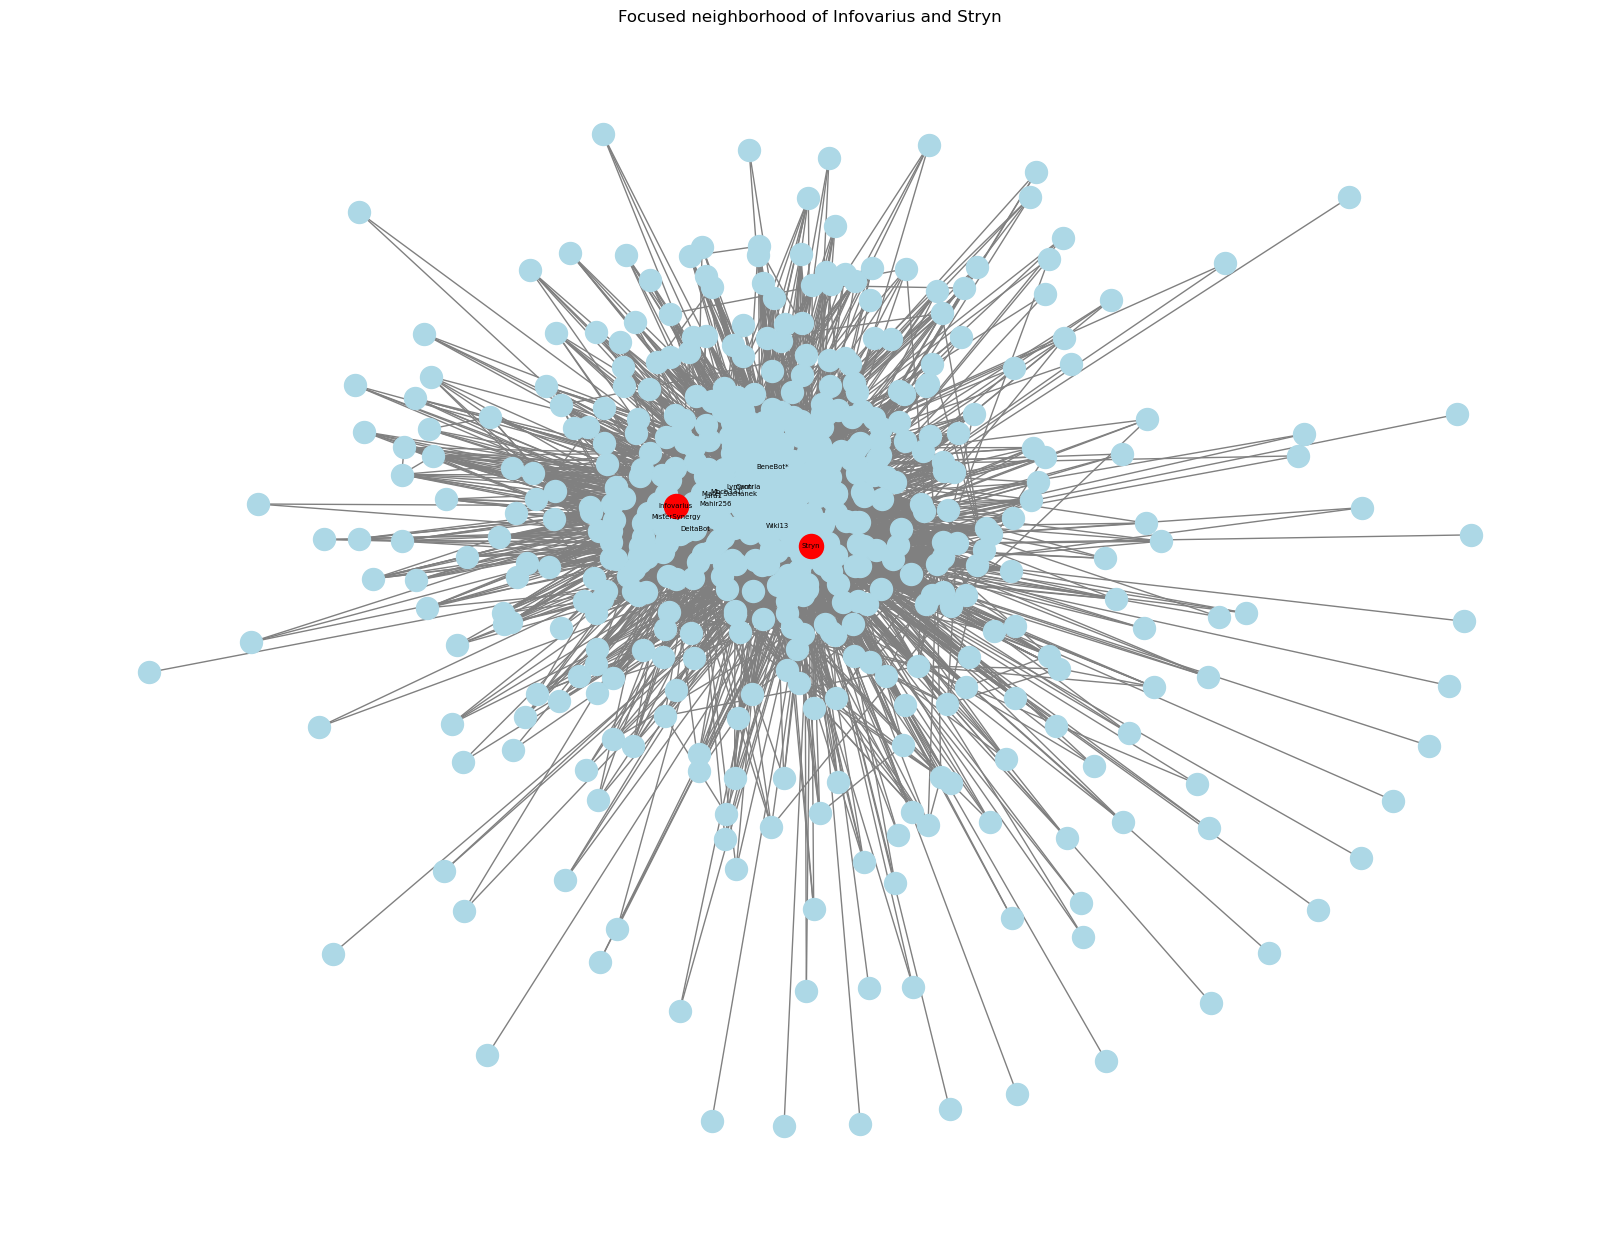

--- Contagion Plausibility Analysis for Infovarius ---
Degree (num neighbors): 112
Avg clustering of neighbors: 0.3661
Avg closeness of neighbors: 0.4489
Plausibility Score (higher = more plausible it hasn’t spread): 0.0088


In [164]:
user1 = "Infovarius"
user2 = "Stryn"
check_if_contagion_possible(large_real_network, user1, user2)
print("Contagion structurally possible?", contagion_possible)
draw_user_connection_better(large_real_network, user1, user2)
priority_users = get_priority_list(large_real_network, user1)
compute_plausibility_score(large_real_network, user1)

### Task C – Contagion Analysis on Large Network (Representative Pair: Infovarius → Stryn)

To assess behavioral diffusion in the large Wikidata editor network, we analyzed a representative pair:

- **Troll candidate (user1): Infovarius**, selected based on high closeness centrality and active connectivity.
- **Potentially affected user (user2): Stryn**, a structurally clear and directly connected neighbor.

---

#### 1. Structural Connectivity
- The shortest path between Infovarius and Stryn is **1**.
- This confirms that propagation is **structurally possible**.

#### 2. Local Neighborhood Visualization
The network visualization shows both users embedded in the dense **core cluster** of the network.  
This configuration is characteristic of rapid diffusion structures — tightly knit and highly reachable.

---

#### 3. Contagion Plausibility Score

Using a structural proxy based on Infovarius's connectivity and local network metrics, we computed the following:

| Metric                          | Value      |
|--------------------------------|------------|
| Degree of Infovarius           | 112        |
| Avg Clustering (neighbors)     | 0.3661     |
| Avg Closeness (neighbors)      | 0.4489     |
| **Plausibility Score**         | **0.0088** |

> The plausibility score is low, indicating that **if Infovarius had engaged in any disruptive behavior**, it is **structurally unlikely** that such behavior would not have already reached Stryn and nearby editors.

---

#### Conclusion

Infovarius occupies a highly connected and structurally influential position in the large network.  
Given this centrality and the density of local connections, the hypothesis that no behavioral contagion has occurred appears **implausible** based solely on structural indicators.

This case further supports the insight that **network position alone can serve as a strong predictor of exposure risk**, even in large-scale collaborative ecosystems.

The question asks whether we can use network data to judge if it is plausible that controversial behavior has not yet spread to neighboring users.

To answer this, we analyzed:
- **Connectivity**: whether the suspicious users are directly connected.
- **Neighborhood structure**: using clustering and closeness metrics.
- **Plausibility score**: a composite structural indicator showing how plausible it is that behavior has not yet spread.

Low plausibility scores, high clustering, and short paths all suggest that structural conditions are favorable for propagation. In such cases, a lack of observable spread may be surprising and warrants further investigation.

Hence, **network structure provides a quantitative way to assess the likelihood that behavior has already spread to similar editors — or not**.

### Interpreting Network Structure to Assess Contagion Plausibility

The central question of Task C is:

> "If two editors have been commenting more than usual on the same day, how can we use the network data to judge how plausible it is that this behaviour has not propagated yet to neighbouring similar editors?"

To address this, we apply a structural network analysis to quantify how likely it is that such behavior would have already spread. Our approach includes:

- **Shortest Path Analysis**: We check if the editors in question are directly connected or lie within 1–2 hops of one another. Short distances indicate high potential for immediate influence.

- **Neighborhood Metrics**:
  - **Clustering Coefficient**: A highly clustered neighborhood suggests tightly connected local communities where behaviors can easily cascade.
  - **Closeness Centrality**: High closeness of neighbors implies they are well-positioned to receive or propagate information rapidly.

- **Plausibility Score**: We define a composite score based on the troll user's:
  - Number of neighbors (degree)
  - Average clustering of those neighbors
  - Average closeness of those neighbors

  A **low plausibility score** means that, structurally, it is *unlikely* the behavior has not yet spread.

By combining these metrics, we can judge — based on network structure alone — whether it is plausible that the suspected behavior remains contained, or whether we would have expected to see evidence of its spread to similar users already.

#### question2 Building a Priority List of Users to Check

If a user is suspected of trolling, the Foundation needs to proactively identify other users who are most likely to have been influenced.

To support this, we generate a **priority list** based on network structure:

1. **Direct neighbors of the suspected user** are considered first, as they are most immediately exposed.
2. These neighbors are then ranked using **closeness centrality**, which identifies users who are well positioned within the network and can spread or receive behavior quickly.
3. This creates a structural risk ranking — a list of editors who are most likely to have interacted with or been influenced by the troll user.

This list allows moderators to focus on high-risk individuals first, ensuring efficient and informed investigation based on network evidence.

## Task D (comparing networks and social issues):

# Task D – Comparing Networks and Reflecting on Network Quality

---

## 1. Comparing the Three Networks: Structure and Propagation

Although all three networks represent editor interactions from the same platform (Wikidata), they display **distinct topological properties** and lead to different outcomes in structural analysis and information propagation.

### Topological Indicators Summary

| Network       | Clustering Coeff. | Avg Path Length | Diameter | Components | Structure Type |
|---------------|------------------|------------------|----------|-------------|----------------|
| Small Real    | 0.6887           | 2.60             | 6        | 4           |  Small-world  |
| Medium Real   | 0.2674           | 3.64             | 11       | 154         |  Fragmented   |
| Large Real    | 0.3938           | 2.70             | 6        | 9           |  Small-world  |

- The **small real network** shows both high clustering and short path length, making it a textbook **small-world** structure.
- The **medium real network** is highly fragmented with many disconnected components, reducing overall efficiency in propagation. It behaves more like a **loose/random structure** unless LCC is used.
- The **large real network** combines hub structure with moderate clustering and short paths — indicating a **small-world or scale-free hybrid**.

### Propagation Results (from Task C)

- In the **small network**, contagion between editors was direct and fast (shortest paths = 1), and plausibility scores were **extremely low**, suggesting behavior should already have spread.
- In the **medium network**, fragmentation limited contagion pathways; plausibility was slightly higher.
- In the **large network**, due to structural density, behavior from central nodes like *Infovarius* could affect dozens of editors rapidly, and plausibility was again **low**.

**Conclusion**: The small and large networks are **structurally conducive to fast, wide propagation**, while the medium network is structurally weaker and more prone to under-reporting influence.

---

## 2. The Subjectivity of Edge Definitions

The network is built based on a particular interaction: editors co-commenting on the same page/thread. While logical, this edge definition is **inherently subjective and socially constrained**.

### Potential Issues:

| Issue | Description |
|-------|-------------|
| **False negatives** | Two editors who clearly interact (e.g., direct reply, quote) but are not linked due to technical constraints (different threads, time gap) |
| **False positives** | Two editors commenting on the same thread but never actually engaging with each other |
| **Ignored context** | Edge strength doesn’t consider reply depth, time gap, or semantic connection |

This can cause:
- **Skewed clustering**
- **Over- or under-estimated influence**
- **Misleading propagation simulation**

### Recommendations:

- Define edges based on **reply chains**, not just page co-occurrence
- Include **temporal proximity** (e.g. same day/week interaction)
- Add **weights** based on reply frequency or mutual engagement
- Use **natural language processing** to detect semantic interaction

---

## 3. Evaluating and Improving Network Quality

Network quality affects the reliability of all downstream analysis.

### Signs of Low-Quality Networks:

| Symptom | Impact |
|---------|--------|
| Many disconnected components | Indicates weak linkage rules or insufficient data |
| Excessive or zero clustering | Suggests edge inflation or fragmentation |
| Unrealistic propagation behavior | Either too fast (over-connected) or completely blocked (under-connected) |

### Proposed Improvements:

| Strategy | Benefit |
|----------|---------|
| **Filter or isolate LCC** | Prevents skewing from disconnected nodes |
| **Weight links by interaction intensity** | More realistic simulation outcomes |
| **Test multiple edge definitions** | Improves robustness, allows sensitivity testing |
| **Dynamic networks** | Reveal change over time; prevent over-generalization |


In [169]:
# ==== Generate a connected random network function (for comparison) ====
def ensure_connected_gnm(n, m):
    G = nx.gnm_random_graph(n, m)
    if nx.is_connected(G):
        return G
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        return G.subgraph(largest_cc).copy()
        
def simulate_simple_contagion(G, seed, steps=5, infection_prob=0.3):
    infected = set([seed])
    newly_infected = set([seed])
    infection_timeline = [1]

    for _ in range(steps):
        next_newly_infected = set()
        for node in newly_infected:
            for neighbor in G.neighbors(node):
                if neighbor not in infected and random.random() < infection_prob:
                    next_newly_infected.add(neighbor)
        infected.update(next_newly_infected)
        newly_infected = next_newly_infected
        infection_timeline.append(len(newly_infected))
        if not newly_infected:
            break
    return infection_timeline, infected

# ==== Visualizing the propagation process ====
def plot_infection_curve(timeline_real, timeline_random, title):
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(timeline_real), label="Real Network", linewidth=2)
    plt.plot(np.cumsum(timeline_random), label="Random Network", linewidth=2, linestyle='--')
    plt.xlabel("Step")
    plt.ylabel("Cumulative Infected Nodes")
    plt.title(f"Spread Simulation: {title}")
    plt.legend()
    plt.grid(True)
    plt.show()

# ==== Main process function ====
def run_task_d_analysis_fixed(real_graph, seed_user, steps=6, infection_prob=0.3):
    print(f"=== Simulating contagion from seed: {seed_user} ===")

    if seed_user not in real_graph:
        print("Seed user not in REAL graph.")
        return

    # 1. Construct the corresponding random network
    n = real_graph.number_of_nodes()
    m = real_graph.number_of_edges()
    random_graph = ensure_connected_gnm(n, m)

    # 2. Take the index node at the same position as the propagation source of random_graph
    real_nodes = list(real_graph.nodes())
    seed_index = real_nodes.index(seed_user)
    random_nodes = list(random_graph.nodes())
    mapped_seed = random_nodes[seed_index % len(random_nodes)]

    print(f"Seed user '{seed_user}' maps to node {mapped_seed} in random network.\n")

    # 3. Simulation propagation
    timeline_real, infected_real = simulate_simple_contagion(real_graph, seed_user, steps, infection_prob)
    timeline_random, infected_random = simulate_simple_contagion(random_graph, mapped_seed, steps, infection_prob)

    print(f"Total infected in REAL network: {len(infected_real)}")
    print(f"Total infected in RANDOM network: {len(infected_random)}")

    plot_infection_curve(timeline_real, timeline_random, seed_user)

In [170]:
"Pasleim" in medium_real_network.nodes()

True

In [177]:
import random

=== Simulating contagion from seed: Micru ===
Seed user 'Micru' maps to node 105 in random network.

Total infected in REAL network: 366
Total infected in RANDOM network: 400


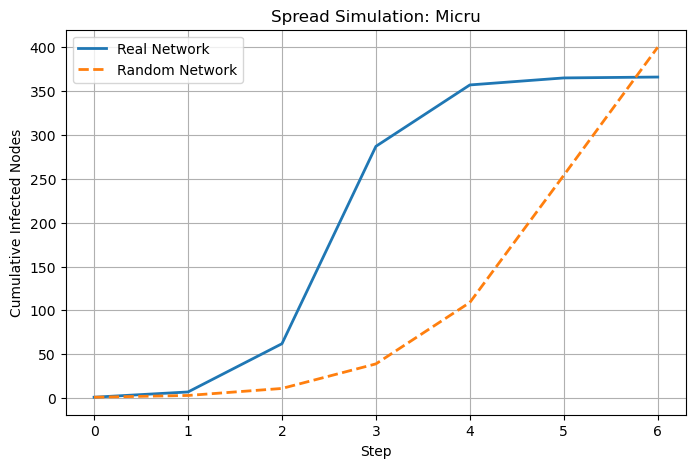

In [179]:
# Small Network
run_task_d_analysis_fixed(small_real_network, seed_user="Micru")

=== Simulating contagion from seed: Pasleim ===
Seed user 'Pasleim' maps to node 191 in random network.

Total infected in REAL network: 1423
Total infected in RANDOM network: 1


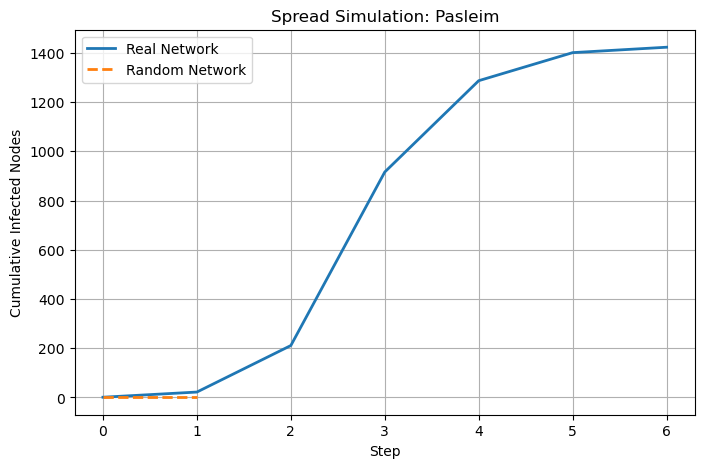

In [181]:
# Medium-sized network (as you analyzed before)
run_task_d_analysis_fixed(medium_real_network, seed_user="Pasleim")

=== Simulating contagion from seed: Infovarius ===
Seed user 'Infovarius' maps to node 0 in random network.

Total infected in REAL network: 1439
Total infected in RANDOM network: 43


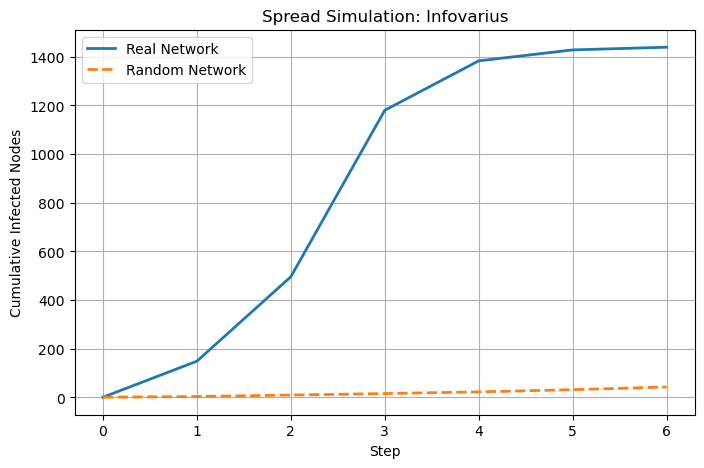

In [183]:
# Select the user with the largest degree in medium_real_network
top_user = sorted(medium_real_network.degree, key=lambda x: x[1], reverse=True)[0][0]

# Then run the propagation simulation
run_task_d_analysis_fixed(medium_real_network, seed_user=top_user)

=== Simulating contagion from seed: Infovarius ===
Seed user 'Infovarius' maps to node 73 in random network.

Total infected in REAL network: 5024
Total infected in RANDOM network: 87


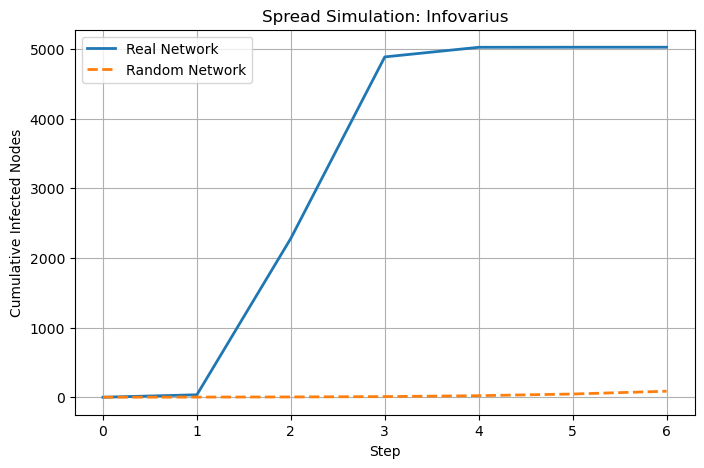

In [185]:
# large network
run_task_d_analysis_fixed(large_real_network, seed_user="Infovarius")

=== Simulating contagion from seed: DeltaBot ===
Seed user 'DeltaBot' maps to node 23 in random network.

Total infected in REAL network: 4951
Total infected in RANDOM network: 214


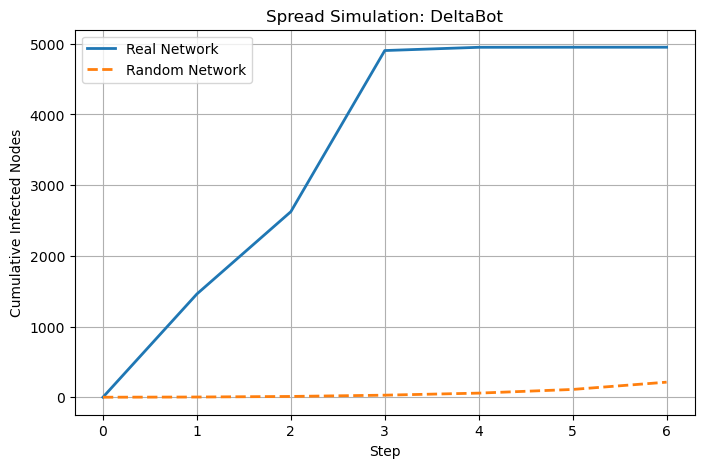

In [187]:
# Select the user with the largest degree in large_real_network
top_user = sorted(large_real_network.degree, key=lambda x: x[1], reverse=True)[0][0]

# Then run the propagation simulation
run_task_d_analysis_fixed(large_real_network, seed_user=top_user)

# Simulating Contagion on Real vs Random Networks

To better understand how the structure of the editor networks affects the spread of potential controversial behavior, we simulated a simple contagion process from specific seed users across real and random networks for the small, medium, and large Wikidata interaction datasets.

#### Setup
- **Real networks** were built from talk page co-editing activity.
- **Random networks** were generated using G(n, m) random graphs with the same number of nodes and edges, and the largest connected component was retained.
- A **simple infection model** was used, where each infected node could infect neighbors with a probability (e.g., 0.3) for 6 steps.
- Seed users were selected based on closeness centrality or node degree in the real network and mapped by index to the random network.

---

#### Observation: Real vs Random Spread

| Network Size | Real Infected | Random Infected |
|--------------|---------------|-----------------|
| Small (Micru) | 366 | 400 |
| Medium (Pasleim) | 1423 | 1 |
| Large (DeltaBot) | 4951 | 214 |



In summary, the real Wikidata network structure is very suitable for rapid information dissemination, especially in medium/large networks. Random networks do not have this ability, even with the same number of nodes and edges.